In [66]:
import pandas as pd
import sqlite3
from datetime import datetime, timedelta, date

def service(code, start_day, end_day, period, drop_holi = 0, stock_moving_avg = 1, day_shift = 0):
    '''
    각 옵션을 입력받아 해당 기간의 데이터를 DB로부터 조회하여 원하는 형태로 가공하여 리턴하는 함수
    code                : 조회할 종목이름
    start_day           : 조회를 시작 날짜
    end_day             : 조회 종료 날짜
    period              : 뉴스 긍부정과 주가를 이동평균 낼 기간
    drop_holi           : 주말 혹은 공휴일 뉴스를 사용할지 여부. 0 (디폴트) - 다음 영업일 주가로 채워서 사용 / 1 - 주말 및 공휴일 데이터는 drop
    stock_moving_avg    : 주가를 이동평균 낼지 여부. 1 (디폴트) - 주가 이동평균 사용 / 0 - 이동평균 사용안함
    day_shift           : 뉴스와 주가의 몇 일의 텀을 두고 분석할 지.  0(디폴트) | +x - 해당일의 뉴스와 다음날의 주가 분석 | -x - 해당일의 뉴스와 전날의 주가 분석 
    '''
    # 이동평균을 고려하여 DB에서 조회할 날짜 설정
    inq_day = (datetime.strptime(str(start_day), "%Y%m%d").date() - timedelta(days = period - 1)).strftime('%Y%m%d')
    end_day = str(end_day)

    # db 경로는 로컬에 맞게 설정해야함
    conn = sqlite3.connect("C:/Projects/python-workspace/2jo_Final_Python2/DB/final.db")

    # 커서 바인딩
    c = conn.cursor()

    # 뉴스데이터 조회
    # query = c.execute(f"select a.id, a.date, a.code, b.senti, b.senti_proba from news_db b join news_id a on b.id = a.id where a.date BETWEEN {inq_day} and {end_day};")
    query = c.execute(f"select a.id, a.date, a.code, b.senti, b.senti_proba from news_db b join news_id a on b.id = a.id where a.code = \'{code}\' and (a.date BETWEEN {inq_day} and {end_day});")
    # 컬럼명 조회
    cols = [column[0] for column in query.description]
    # 데이터 프레임으로 만들기
    news_result = pd.DataFrame.from_records(data=query.fetchall(), columns=cols)

    # 커서 닫기 - 일단 주석처리함
    # conn.close()

    # 주가 데이터 조회
    query = c.execute(f"select s_date, s_code, close-open from stock_db where s_code = \'{code}\' and (s_date BETWEEN {inq_day} and {end_day});")
    # 컬럼명 조회
    cols = [column[0] for column in query.description]
    # 데이터 프레임으로 만들기
    stock_result = pd.DataFrame.from_records(data=query.fetchall(), columns=cols)
    stock_result.rename(columns={'s_date': 'date', 's_code': 'code', 'close-open': 'UpDown'}, inplace=True)
    
    # 주말 및 공휴일 drop 여부는 옵션에 따라; 디폴트는 드랍안함
    if drop_holi:
        # 주말이나 공휴일 등으로 주가가 빠진 날은 drop
        merge_outer_df = pd.merge(news_result,stock_result, how='outer',on='date')
        merge_outer_df = merge_outer_df.dropna(subset=['UpDown'])
    else:
        # 주말이나 공휴일 등으로 주가가 빠진 날은 다음 Business Day의 주가로 채워줌
        merge_outer_df = pd.merge(news_result,stock_result, how='outer',on='date').fillna(method='bfill')

    dateg = merge_outer_df.groupby(['date']).mean()
    dateg = dateg[['senti', 'UpDown']]
    dateg = dateg.reset_index()

    # 설정한 기간에 따라 뉴스 긍부정 이동평균
    dateg['senti_moving_avg'] = dateg['senti'].rolling(window=period).mean()

    # 주가의 이동평균은 옵션에 따라 결정; 디폴트는 이동평균 사용
    if stock_moving_avg:
        dateg['UpDown_moving_avg'] = dateg['UpDown']
    else:
        dateg['UpDown_moving_avg'] = dateg['UpDown'].rolling(window=period).mean()

    dateg = dateg[['date', 'senti_moving_avg', 'UpDown_moving_avg']]

    # 뉴스와 주가사이의 텀 설정
    dateg['UpDown_moving_avg'] = dateg['UpDown_moving_avg'].shift(day_shift)
    dateg.dropna(inplace=True)
    
    return dateg

In [91]:
# 정의한 함수 실행
result = service('네이버', 20210401, 20210501, 3, drop_holi = 0, stock_moving_avg = 1, day_shift = 3)
result.head()

,date,senti_moving_avg,UpDown_moving_avg
3,20210402,0.253292,3000.0
4,20210403,0.214484,-2500.0
5,20210404,0.145688,3001.0
6,20210405,0.154756,-2000.0
7,20210406,0.204664,-2500.0


In [92]:
# 열 정규화 하기
import pandas as pd
from sklearn import preprocessing

date_c = list(result['date'])

x = result.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
result = pd.DataFrame(x_scaled, columns=result.columns)
result['date'] = date_c
# result['date'] = result['date'].astype(str)
# result['date'] = pd.to_datetime(result['date'])
result.head()

,date,senti_moving_avg,UpDown_moving_avg
0,20210402,0.492973,0.621622
1,20210403,0.402745,0.324324
2,20210404,0.242796,0.621676
3,20210405,0.263879,0.351351
4,20210406,0.379915,0.324324


In [97]:
def date_corNews_list(corr_df:pd.DataFrame)-> list:

    import datetime
    import time

    date_list= corr_df['date'].values.tolist()
    for index in range(len(corr_df['date'])):

        # string 타입의 날짜 형식을 datetime 타입으로 변환
        datetime_date=datetime.datetime.strptime(str(date_list[index]), '%Y%m%d')

        # datetime 타입을 unixtime으로 변환
        # *1000 : 분, 초 포함하도록
        unix_date=(time.mktime(datetime_date.timetuple()))*1000

        # unixtime을 int값으로 변환 후 데이터 프레임에 넣기
        date_list[index] = int(float(unix_date))
    
    date_df=pd.DataFrame(date_list,  columns=['date'])
    corr_df=pd.concat([date_df, corr_df['senti_moving_avg']], axis=1)

    corr_list=corr_df.values.tolist()
    return corr_list

In [98]:
date_corNews_list(result)

[[1617289200000.0, 0.492972576747966],
 [1617375600000.0, 0.40274489400625385],
 [1617462000000.0, 0.2427958200550368],
 [1617548400000.0, 0.2638790743193785],
 [1617634800000.0, 0.379914866569801],
 [1617721200000.0, 0.5225837280673598],
 [1617807600000.0, 0.27685476457261843],
 [1617894000000.0, 0.11204329317773142],
 [1617980400000.0, 0.1102819492086257],
 [1618066800000.0, 0.3150560854542435],
 [1618153200000.0, 0.5519264812994878],
 [1618239600000.0, 0.4676129667127905],
 [1618326000000.0, 0.6747647416956578],
 [1618412400000.0, 0.6552945157514554],
 [1618498800000.0, 0.7550734895790805],
 [1618585200000.0, 1.0],
 [1618671600000.0, 0.9704765201368957],
 [1618758000000.0, 0.928171533747691],
 [1618844400000.0, 0.679067172402747],
 [1618930800000.0, 0.4303045180006634],
 [1619017200000.0, 0.4142591485098457],
 [1619103600000.0, 0.23115679743578443],
 [1619190000000.0, 0.3624965205641574],
 [1619276400000.0, 0.4324790167279544],
 [1619362800000.0, 0.49010657838382177],
 [161944920000

In [81]:
def list_datetime_to_unixtime(date_list:list)-> list:
    """
    날짜데이터를 unixtime으로 바꿔주는 함수  
    date_list        : list type 
    """
    import datetime
    # list 타입의 데이터를 데이터 프레임화

    # db로부터 조회한 데이터를 데이터프레임에 씌우면 컬럼값이 0, 1, 2 ...
    # 보통 첫번째 컬럼이 date컬럼인 경우가 많아 0으로 설정
    for index in range(len(date_list)):

        # string 타입의 날짜 형식을 datetime 타입으로 변환
        datetime_date=datetime.datetime.strptime(str(date_list[index]), '%Y%m%d')

        # datetime 타입을 unixtime으로 변환
        # *1000 : 분, 초 포함하도록
        unix_date=(time.mktime(datetime_date.timetuple()))*1000

        # unixtime을 int값으로 변환 후 데이터 프레임에 넣기
        date_list[index] = int(float(unix_date))

    return date_list

In [82]:
date_list=result['date'].values.tolist()
list_datetime_to_unixtime(date_list)

[1617289200000,
 1617375600000,
 1617462000000,
 1617548400000,
 1617634800000,
 1617721200000,
 1617807600000,
 1617894000000,
 1617980400000,
 1618066800000,
 1618153200000,
 1618239600000,
 1618326000000,
 1618412400000,
 1618498800000,
 1618585200000,
 1618671600000,
 1618758000000,
 1618844400000,
 1618930800000,
 1619017200000,
 1619103600000,
 1619190000000,
 1619276400000,
 1619362800000,
 1619449200000,
 1619535600000,
 1619622000000,
 1619708400000,
 1619794800000]

In [63]:
import datetime
str_date="20220305"
datetime_date=datetime.datetime.strptime(str_date, '%Y%m%d')
unix_date=time.mktime(datetime_date.timetuple())
str_date=float(unix_date*1000)
int_date=int(str_date)
print(int_date,type(int_date))

1646406000000 <class 'int'>


(array([18718., 18722., 18726., 18730., 18734., 18738., 18742., 18746.,
        18748.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

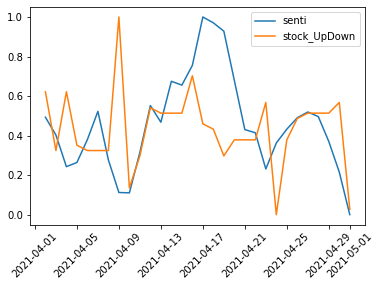

In [14]:
# 긍부정과 상관관계 그래프 도시
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ax = sns.scatterplot(data=result, x='senti_moving_avg', y='UpDown_moving_avg')
# fig, axe1 = plt.subplots()
# axe2 = axe1.twinx()
# c1 = sns.lineplot(ax = axe1, data = result, x = 'date', y = 'senti_moving_avg', color = 'red')
# c2 = sns.lineplot(ax = axe2, data = result, x = 'date', y = 'UpDown_moving_avg', color = 'blue')

plt.plot(result['date'], result['senti_moving_avg'], label = 'senti') 
plt.plot(result['date'], result['UpDown_moving_avg'], label='stock_UpDown')
plt.legend()
plt.xticks(rotation=45)

<AxesSubplot:>

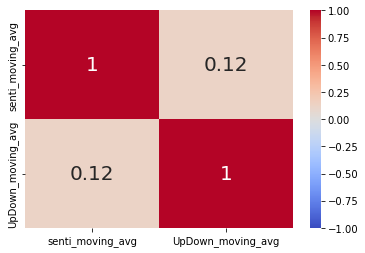

In [15]:
# 상관계수 찍어보기
pairplot = result
sns.heatmap(pairplot.corr(), vmin=-1, vmax=1, annot=True, cmap="coolwarm", annot_kws={'size' : 20})